In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

In [ ]:
training_data = "/content/drive/MyDrive/FER2013/train" # Directory containing the training data
test_data = "/content/drive/MyDrive/FER2013/test"  # Directory containing the validation dat

In [ ]:
d ={}
for folder in sorted(os.listdir(training_data)):
    folder_path = os.path.join(training_data,folder)
    d[folder] = []
    for image in os.listdir(folder_path)[:5]:
        image_path = os.path.join(folder_path,image)
        image = np.array(Image.open(image_path))
        d[folder].append(image)

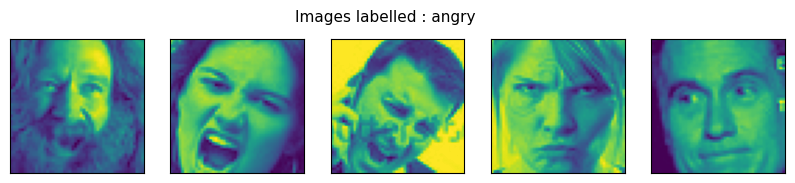

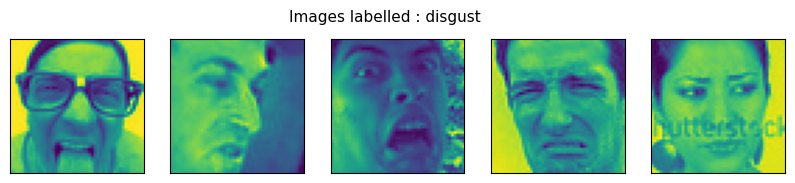

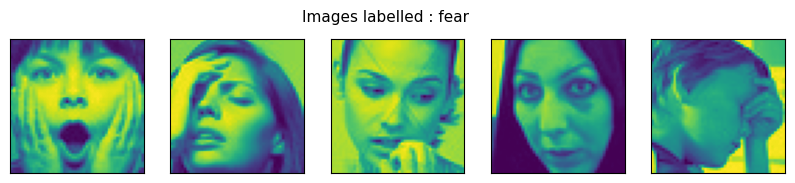

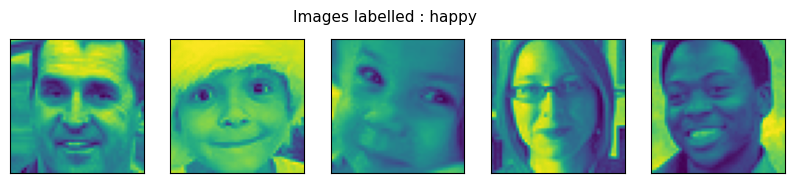

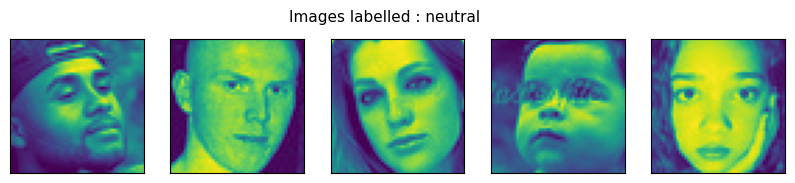

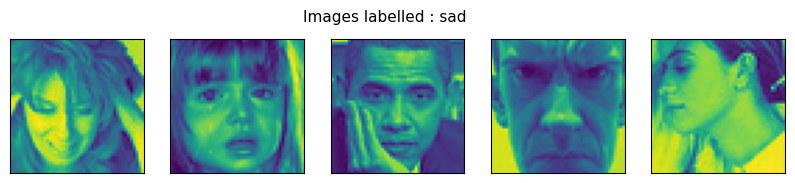

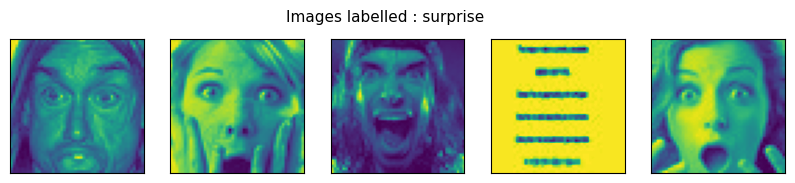

In [ ]:
def plot_images(d,label):
    fig, ax = plt.subplots(1,5, figsize = (10,2))
    fig.suptitle('Images labelled : {}' .format(label), fontsize=11)
    for col in range(5):
        ax[col].imshow(d[label][col])
        ax[col].tick_params(
        axis = 'both',
        which='both',
        bottom=False,
        left = False,
        top=False,
        labelbottom=False,
        labelleft=False)

for key in d.keys():
    plot_images(d,key)

In [ ]:
train_aug = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=25, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.2,
        zoom_range=0.2,horizontal_flip=True,
        fill_mode="nearest")
val_aug = ImageDataGenerator(
        preprocessing_function=preprocess_input
)

In [ ]:
train_data = train_aug.flow_from_directory(
            training_data,
            target_size = (48,48),
            shuffle = True)
val_data = val_aug.flow_from_directory(
        test_data,
        target_size = (48,48),
        shuffle = False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
def ModelImages():

    model = Sequential()
    model.add(Conv2D(64,(3,3),padding = "same", activation = "relu", input_shape = (48,48,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation = "relu",padding = "same"))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation = "relu",padding = "same"))

    model.add(MaxPool2D(2,2))
    model.add(Conv2D(128,(3,3), activation = "relu",padding = "same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation = "relu",padding = "same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation = "relu",padding = "same"))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(256,(3,3), activation = "relu",padding = "same"))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation = "relu",padding = "same"))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation = "relu",padding = "same"))
    model.add(MaxPool2D(2,2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(7, activation='softmax'))
    return model

In [ ]:
model = ModelImages()

In [ ]:
model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_21 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_22 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)      

In [ ]:
model.fit(train_data,epochs = 50,validation_data = val_data)

NameError: ignored

In [ ]:
y_pred = model.predict_generator(val_data)
y_pred_classes = np.argmax(y_pred, axis = 1)

ConfusionMatrixDisplay(confusion_matrix(val_data.classes,y_pred_classes),
                       display_labels=list(train_data.class_indices.keys())).plot()

In [ ]:
def get_label(i):
    return list(train_data.class_indices.keys())[i]

In [ ]:
X_test = []

test_path = "/content/drive/MyDrive/FER2013/test"

for folder in sorted(os.listdir(test_path)):
    image_folder =  test_path +"/"+ folder
    images = sorted(os.listdir(image_folder))
    print ('Loaded the images of -'+'{} having {} images. \n'.format(folder, len(images)))
    for image in images:
        image_path = image_folder +"/"+ image
        x = Image.open(image_path)
        x = x.convert("RGB")
        x = np.array(x)
        img_resize = cv2.resize(x, (224,224))
        X_test.append(img_resize)

In [ ]:
def plot_errors(true_label,predicted_label):
    rows,cols = 1,5
    fig, ax = plt.subplots(rows,cols,figsize=(10, 3))
    x = ((y_pred_classes == predicted_label) & (val_data.classes == true_label))
    y = np.where(x == True)[0]
    z = np.random.randint(0,len(y),5)
    fig.suptitle('Predicted : {}, Real : {}' .format(get_label(predicted_label), get_label(true_label)), fontsize=11)
    for col in range(cols):
        ax[col].imshow(X_test[y[z[col]]])
        ax[col].tick_params(
        axis = 'both',
        which='both',
        bottom=False,
        left = False,
        top=False,
        labelbottom=False,
        labelleft=False)

In [ ]:
plot_errors(0,5)
plot_errors(1,0)
plot_errors(5,0)
plot_errors(2,5)
plot_errors(2,6)

In [ ]:
def ArrayChallenge(arr):

  if len(arr) < 2:
    return -1

    max_profit = 0
    min_price = arr[0]

    for price in arr:
      if price < min_price:
        min_price = price
      else:
        max_profit = max(max_profit, price - min_price)

    if max_profit == 0:
      return -1

    return max_profit

# Test cases
print(ArrayChallenge([10, 12, 4, 5, 9]))  # Output: 5
print(ArrayChallenge([14, 20, 4, 12, 5, 11]))  # Output: 8
print(ArrayChallenge([10, 9, 8, 2]))  # Output: -1

None
None
None


In [ ]:
import requests
import numpy as np
import pandas as pd

r = requests.get('https://coderbyte.com/api/challenges/json/age-counting')
print(len(r.json()['data']))

data = r.json()["data"].split(",")

count = 0
for data in data:
  split_data = data.split("=")
  if split_data[0].strip() == "age" and int(split_data[1]) >= 50:
    count += 1

print(count)

5660
128
